## Logistic Regression:
In statistics, the **logistic model** (or logit model) is used to model the probability of a certain class or event existing. In this experiment, we are considering the probability of a handwritten character being written by a **Male(labeled as 0)** or **Female(labeled as 1)**. **Binary Logistic regression** is a statistical model that uses a logistic function to model a binary dependent variable while in its basic form. Mathematically, a binary logistic model (like the one we are implementing in the current experiment) has a dependent variable with two possible values, such as male/female, which is represented by an indicator variable, where the two values are labeled "0" and "1". Logistic regression gives the probability of a certain input belonging to a class. The function that converts log-odds to probability is the **logistic function**. Logistic regression is used in various fields, including machine learning. Here, we are using this incredibly useful method to differentiate between handwritten data and categorize them.
 


## Ekush Dataset: 
This is a Multipurpose and Multitype Comprehensive **Database** for Online and Off-Line **Bangla Handwritten Characters**.
It consists of 673,482‬ instances of Bangla handwritten characters, which can help in the following cases:


*   Characters Recognition
*   Recognition in context
*   **Gender Identification**
*   Forensic Investigation

For the given experiment we are to perform the following: Apply only logistic regression for the Ekush dataset and build a binary classification model that can predict male/female from Bengali handwritten digits with different hyperparameter settings.


For this task, we will use the Ekush dataset for Gender Identification purposes. Hence we will use the Female Digits and Male Digits portion of the Ekush Dataset for logistic regression.



In the given experiment, we are using the following fixed hyper-parameters:

- **Input dimension: 784**
  - Size of image: $28 \times 28 = 784$

- **Output dimension: 2**
  - 0(male), 1(female)

The images in Ekush Dataset are stored as 1D arrays in CSV files where the first 784 columns denote the intensity levels of the pixels in an image and the last column denotes the Label which indicates the digit written in the image. Here we drop the existing column for Labels and add an extra column in its place, which contains the value of either 0(for male) or 1(for female).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset
import matplotlib
import matplotlib.pyplot as plt
import io
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from datetime import datetime
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**In the above cell, we imported all the required libraries needed to perform logistic regression, plot the data etc. and mounted Google Drive in order to import required files and save the model in the end.**

In [ ]:
# Hyperparameters
input_dim = 28*28 # num_features = 784
output_dim = 2

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

Tesla T4


In [ ]:
#INITIALIZING DATASETS

female_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/femaleDigits.csv"
male_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/maleDigits.csv"
femaleData = pd.read_csv(female_path)
maleData = pd.read_csv(male_path)
femaleImage = femaleData.to_numpy()[:, : input_dim]
maleImage = maleData.to_numpy()[:, : input_dim]
images = np.concatenate((femaleImage, maleImage), axis=0)

#Labeling females=1 and males=0
labels = np.zeros(images.shape[0], dtype=np.long)
labels[: femaleImage.shape[0]] = 1

**In the above cell we imported the 2 datasets from Google drive where it was saved previously, we combined the two and finally added a new label to indicate genders after dropping the previous label that indicated digits.**

In [ ]:
#FUNCTION FOR PRINTING CURRENT TIME
def curr_time():
  now = datetime.now()
  current_time = now.strftime("%H:%M:%S") 
  print("Current Time =", current_time)


**In the following cell, class Dataset is declared, which normalizes the data in a [0,1] range and returns image and label.**

In [ ]:
#CLASS FOR DEFINING DATASETS OF EKUSH DB
class Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        image = self.images[index]
        image = (image / 255.0).astype(np.float32)
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

## Logistic Regression consists of three steps, which we will now execute one by one, and subsequently repeat for hyper-parameter tuning purposes.
## **Step 1: Designing model using Class**
**In the following cell, we declared the class Logistic Regression Model and implemented init function as well as the forward function that executes the softmax function inside and returns logits and probas.**

In [ ]:
#CLASS FOR DEFINING LOGISTIC REGRESSION MODEL
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas


## **Step 2:  Constructing loss and optimizer**
**In the following cell, model is designed using the previously implemented Class, which is part of Step 1. Subsequently, the optimizer is declared, which is Step 2. Here, SGD optimizer is being used.**


In [ ]:
#FUNCTION FOR DEFINING MODEL AND OPTIMIZER
def model_and_optimizer(l_rate):
  '''
  INSTANTIATE MODEL CLASS
  '''
  learning_rate=l_rate
  model = LogisticRegressionModel(input_size=input_dim,
                                  num_classes=output_dim)
  # To enable GPU
  model.to(device)

  # INSTANTIATE OPTIMIZER CLASS
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  return optimizer,model


**In the following cell, dataset is split in a 90:10 ratio for train:test. The data is subsequently loaded into the data loaders.**

In [ ]:
#FUNCTION FOR SPLITTING DATA INTO TRAIN-SET AND TEST-SET AND INITIALIZING DATA LOADERS
def data_splitting_and_loading(iters,batch):
  num_iters=iters
  batch_size=batch
  #SPLITTING DATA INTO 90:10 RATIO
  training_dataset, testing_dataset, y_train, y_test = train_test_split(images,
                                                                        labels, 
                                                                        test_size=0.1,
                                                                        random_state=50)

  train_dataset = Dataset(training_dataset, y_train)

  test_dataset = Dataset(testing_dataset, y_test)

  num_train=len(train_dataset)
  num_test=len(test_dataset)
  print('Total training data=',num_train)
  print('Total testing data=',num_test)

  '''
  MAKING DATASET ITERABLE
  '''
  num_epochs = num_iters / (len(train_dataset) / batch_size)
  num_epochs = int(num_epochs)
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size,
                                                shuffle=True)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)
  return num_train,train_loader,test_loader


## **Step 3 : Training: forward, loss, backward, step**
**In the following cell, data is trained, forward pass performed, loss calculated, backward pass perfomed whereby parameters are updated for next iterations. Accuracy is calculated every 500 iterations.**

In [ ]:
#FUNCTION FOR TRAINING MODEL, CALCULATING ACCURACY & LOSS
def model_training(batch,iters,l_rate,num_tr,train_load,test_load,optim,modl):
  batch_size=batch
  num_iters=iters
  learning_rate=l_rate
  iteration_loss = []
  iter = 0
  curr_time()
  num_train=num_tr
  num_epochs = num_iters / (num_train / batch_size)
  num_epochs = int(num_epochs)
  train_loader=train_load
  test_loader=test_load
  optimizer=optim
  model=modl
  print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
  print('-----------------------------------------------------------------------------------------------------------------------------------')
  for epoch in range(num_epochs):
      print('Epoch:',epoch+1)
      for i, (images, labels) in enumerate(train_loader):

          images = images.view(images.shape[0], -1).to(device)
          labels = labels.to(device)

          # Clear gradients w.r.t. parameters
          optimizer.zero_grad()

          # Forward pass to get output/logits
          logits, probas = model(images) 

          # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
          loss = F.cross_entropy(logits, labels)

          # Getting gradients w.r.t. parameters
          loss.backward()

          # Updating parameters
          optimizer.step()

          iter += 1

          if iter % 500 == 0:
              # Calculate Accuracy         
              correct = 0
              total = 0
              # Iterate through test dataset
              for images, labels in test_loader:
                
                  images = images.view(images.shape[0], -1).to(device)

                  # Forward pass only to get logits/output
                  logits, probas = model(images)

                  # Get predictions from the maximum value
                  _, predicted = torch.max(probas, 1)

                  # Total number of labels
                  total += labels.size(0)


                  # Total correct predictions
                  if torch.cuda.is_available():
                      correct += (predicted.cpu() == labels.cpu()).sum() 
                  else:
                      correct += (predicted == labels).sum()

              accuracy = 100 * correct.item() / total

              # Print Loss
              iteration_loss.append(loss.item())
              print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
  print('-----------------------Simulation ends----------------------')
  curr_time()
  plot(iteration_loss)

**In the following function, cross entropy loss for the logistic regression is plotted in a graph form for better visualization of data.**

In [ ]:
#FUNCTION FOR PLOTTING LOSS 
def plot(iteration_loss):
  print (iteration_loss)
  plt.plot(iteration_loss)
  plt.ylabel('Cross Entropy Loss')
  plt.xlabel('Iteration (in every 500)')
  plt.show()

# SETTING 1: Setting a baseline
**Before moving on to hyper-parameter tuning, we must first set a baseline. From this baseline, we can subsequently change each hyper-parameter one by one in both directions(higher and lower) and finally settle on an optimal combination of parameters.**

Initially we are considering the following hyper-parameters:


*   Batch size: **100**
*   Iterations: **5000**
*   Learning Rate: **0.001**
*   Optimizer: **SGD (Stochastic gradient descent)**
*   Epoch (derived variable): **$iterations \div \frac{totaldata}{minibatch}$**




Total training data= 27747
Total testing data= 3083
Current Time = 06:08:16
Batch size: 100 ; Number of iterations: 5000 ; Learning rate: 0.001 ; Total training data size: 27747 ; Epoch size: 18
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Iteration: 500. Loss: 0.6828101873397827. Accuracy: 55.400583846902364
Epoch: 3
Epoch: 4
Iteration: 1000. Loss: 0.6860493421554565. Accuracy: 56.73045734674019
Epoch: 5
Epoch: 6
Iteration: 1500. Loss: 0.6691892147064209. Accuracy: 57.184560493026275
Epoch: 7
Epoch: 8
Iteration: 2000. Loss: 0.6913579702377319. Accuracy: 57.67109957833279
Epoch: 9
Iteration: 2500. Loss: 0.6614636182785034. Accuracy: 57.57379176127149
Epoch: 10
Epoch: 11
Iteration: 3000. Loss: 0.6906664371490479. Accuracy: 58.44956211482322
Epoch: 12
Epoch: 13
Iteration: 3500. Loss: 0.6614827513694763. Accuracy: 58.19007460265975
Epoch: 14
Epoch: 15
Iteration: 4000. Loss: 0.694916248

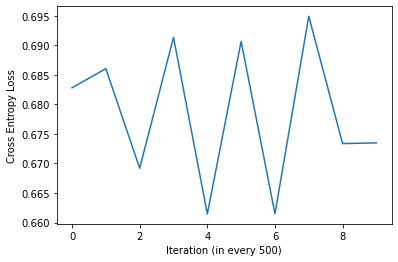

In [ ]:
#HYPERPARAMETERS
batch_size = 100
num_iters = 5000
learning_rate = 0.001
optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)

**Here, we can see from the plotted data that the cross entropy loss is behaving very erratically. The growth in accuracy also isn't very high (59.03-55.4)% = 3.63%, and maximum accuracy achieved is 59.03%. So we must adjust the hyperparameters in order to achieve better accuracy and possibly more stable perfomance.**

# EXPERIMENTING WITH BATCH SIZE

We first attempt to tune the hyper-parameter **batch-size**. So we will perform 4 experiments. As we have already seen the performance of **batch-size=100**, now we will try the same experiment with 4 other values, which are:
* Batch-size: 200
* Batch-size: 150
* Batch-size: 75
* Batch-size: 50

Here, 2 values are higher than the baseline value that was used, and 2 are lower. By this gradual increasing and decreasing process, we can determine which value will be optimal for the hyper-parameter in the subsequent experiments for tuning the other hyperparameters. The values of the other hyper-parameters will remain constant for these 4 experiments:
* Learning-rate: 0.001
* Number of iterations: 5000
* Optimizer: SGD



## SETTING 2: Batch-size=200

Total training data= 27747
Total testing data= 3083
Current Time = 06:08:26
Batch size: 200 ; Number of iterations: 5000 ; Learning rate: 0.001 ; Total training data size: 27747 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Iteration: 500. Loss: 0.6953520774841309. Accuracy: 53.81122283490107
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Iteration: 1000. Loss: 0.6945003271102905. Accuracy: 55.400583846902364
Epoch: 9
Epoch: 10
Epoch: 11
Iteration: 1500. Loss: 0.664764940738678. Accuracy: 56.95750891988323
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Iteration: 2000. Loss: 0.6755246520042419. Accuracy: 57.7684073953941
Epoch: 16
Epoch: 17
Epoch: 18
Iteration: 2500. Loss: 0.6785174608230591. Accuracy: 58.19007460265975
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Iteration: 3000. Loss: 0.6967839598655701. Accuracy: 58.57930587090496
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 2

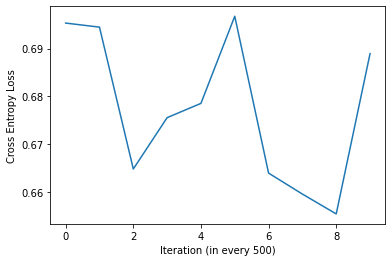

In [ ]:
#HYPERPARAMETERS
batch_size = 200
num_iters = 5000
learning_rate = 0.001

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## SETTING 3: Batch-size = 150

Total training data= 27747
Total testing data= 3083
Current Time = 06:20:13
Batch size: 150 ; Number of iterations: 5000 ; Learning rate: 0.001 ; Total training data size: 27747 ; Epoch size: 27
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6926432847976685. Accuracy: 55.62763542004541
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6942698359489441. Accuracy: 57.249432371067144
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.654323160648346. Accuracy: 58.027894907557574
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6953192353248596. Accuracy: 58.67661368796627
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.7001311182975769. Accuracy: 59.03340901719105
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6541997194290161. Accuracy: 59.519948102497565
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6798819303512573. Accuracy: 59.487512163

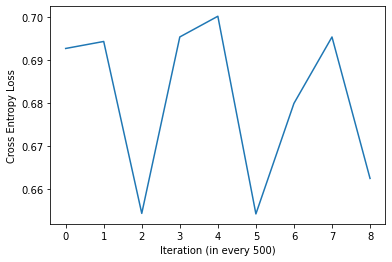

In [ ]:
#HYPERPARAMETERS
batch_size = 150
num_iters = 5000
learning_rate = 0.001

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## SETTING 4: Batch-size = 75

Total training data= 27747
Total testing data= 3083
Current Time = 13:07:54
Batch size: 75 ; Number of iterations: 5000 ; Learning rate: 0.001 ; Total training data size: 27747 ; Epoch size: 13
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Iteration: 500. Loss: 0.6908264756202698. Accuracy: 53.58417126175803
Epoch: 3
Iteration: 1000. Loss: 0.6957826018333435. Accuracy: 56.69802140771975
Epoch: 4
Epoch: 5
Iteration: 1500. Loss: 0.6621307730674744. Accuracy: 57.08725267596497
Epoch: 6
Iteration: 2000. Loss: 0.6891429424285889. Accuracy: 57.995458968537136
Epoch: 7
Iteration: 2500. Loss: 0.6667520999908447. Accuracy: 58.25494648070062
Epoch: 8
Epoch: 9
Iteration: 3000. Loss: 0.661666989326477. Accuracy: 58.384690236782355
Epoch: 10
Iteration: 3500. Loss: 0.6768954992294312. Accuracy: 58.83879338306844
Epoch: 11
Iteration: 4000. Loss: 0.7027139067649841. Accuracy: 58.83879338306844
Epoch

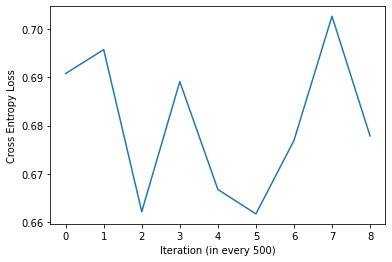

In [ ]:
#HYPERPARAMETERS
batch_size = 75
num_iters = 5000
learning_rate = 0.001

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## SETTING 5: Batch-size=50

Total training data= 27747
Total testing data= 3083
Current Time = 06:08:42
Batch size: 50 ; Number of iterations: 5000 ; Learning rate: 0.001 ; Total training data size: 27747 ; Epoch size: 9
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Iteration: 500. Loss: 0.6718286275863647. Accuracy: 52.48134933506325
Epoch: 2
Iteration: 1000. Loss: 0.674999475479126. Accuracy: 56.406097956535845
Epoch: 3
Iteration: 1500. Loss: 0.6891838312149048. Accuracy: 55.49789166396367
Epoch: 4
Iteration: 2000. Loss: 0.6702779531478882. Accuracy: 57.184560493026275
Epoch: 5
Iteration: 2500. Loss: 0.7066782116889954. Accuracy: 56.73045734674019
Epoch: 6
Iteration: 3000. Loss: 0.6745509505271912. Accuracy: 57.995458968537136
Epoch: 7
Iteration: 3500. Loss: 0.6710949540138245. Accuracy: 57.7684073953941
Epoch: 8
Iteration: 4000. Loss: 0.7051055431365967. Accuracy: 58.19007460265975
Epoch: 9
Iteration: 4500. Loss: 0.6

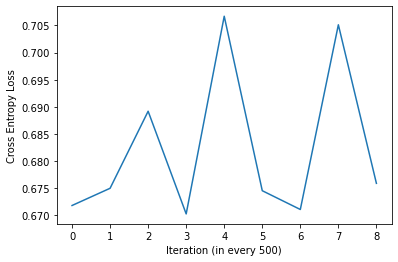

In [ ]:
#HYPERPARAMETERS
batch_size = 50
num_iters = 5000
learning_rate = 0.001

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## **OBSERVATIONS AFTER EXPERIMENTING WITH BATCH-SIZE:-**


---

Now we can compare the data for the 5 settings, where the learning rate, iterations and optimizer were static and only the batch size was varied, in order to determine which batch size we will use moving forward. A table is shown as follows:

|     Criteria     | Batch Size = 100 | Batch Size = 200 | Batch Size = 150 | Batch Size = 75 | Batch Size = 50 |
| :--------------- | :--------------: | :-------------: | :--------------: | :--------------: | :--------------: |
| Initial Accuracy |      55.40%      |     53.81%      |      55.62%      |     53.58%      |      52.48%      |
| Highest Accuracy |      59.03%      |     58.57%      |      **59.55%**      |     59.06%      |      58.19%      |
| Final Accuracy   |      59.03%      |     58.38%      |      **59.16%**      |     59.06%      |      58.09%      || 

We will consider the highest accuracy (59.55%) as well as the highest final accuracy (59.16%) was achieved with **Batch size = 150** and moving forward, we will use this value for the subsequent experiments.

# EXPERIMENTING WITH ITERATIONS:
Now we will attempt to tune the hyper-parameter **iterations**. So we will perform 4 experiments. As we have already seen the performance of **iteration = 5000**, now we will try the same experiment with 4 other values, which are:
* Iterations: 20000
* Iterations: 10000
* Iterations: 3000
* Iterations: 2500

Here, 2 values are higher than the baseline value that was used, and 2 are lower. By this gradual increasing and decreasing process, we can determine which value will be optimal for the hyper-parameter in the subsequent experiments for tuning the other hyperparameters. The values of the other hyper-parameters will remain constant for these 4 experiments:
* Batch-size: 150
* Learning-rate: 0.001
* Optimizer: SGD



## SETTING 6: Iteration Number=20000

Total training data= 27747
Total testing data= 3083
Current Time = 06:33:32
Batch size: 150 ; Number of iterations: 20000 ; Learning rate: 0.001 ; Total training data size: 27747 ; Epoch size: 108
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6970668435096741. Accuracy: 53.90853065196237
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6704973578453064. Accuracy: 57.67109957833279
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6790947318077087. Accuracy: 58.90366526110931
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6739820241928101. Accuracy: 59.163152773272785
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6699257493019104. Accuracy: 59.552384041518
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6710731983184814. Accuracy: 59.584819980538434
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6702578663825989. Accuracy: 59.552384041

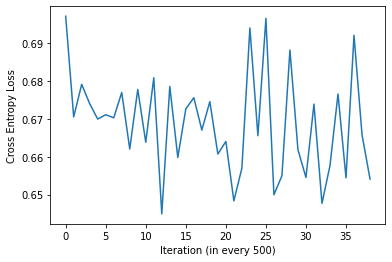

In [ ]:
#HYPERPARAMETERS
batch_size = 150
num_iters = 20000
learning_rate = 0.001

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## SETTING 7: Iteration Number=10000

Total training data= 27747
Total testing data= 3083
Current Time = 06:32:43
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.001 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6857919096946716. Accuracy: 54.91404476159585
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6898747682571411. Accuracy: 56.37366201751541
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6942691206932068. Accuracy: 57.67109957833279
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6890076994895935. Accuracy: 58.19007460265975
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6766923069953918. Accuracy: 58.6117418099254
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6589598655700684. Accuracy: 58.93610120012974
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6718552112579346. Accuracy: 59.51994810249

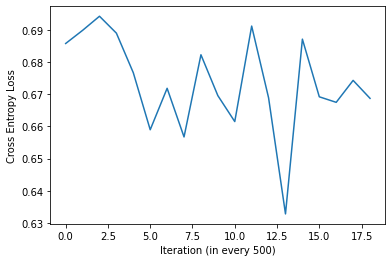

In [ ]:
#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.001

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## SETTING 8: Iteration Number=3000

Total training data= 27747
Total testing data= 3083
Current Time = 06:36:16
Batch size: 150 ; Number of iterations: 3000 ; Learning rate: 0.001 ; Total training data size: 27747 ; Epoch size: 16
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6913836598396301. Accuracy: 56.081738566331495
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6815613508224487. Accuracy: 57.57379176127149
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.696198046207428. Accuracy: 58.12520272461888
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6719512343406677. Accuracy: 58.57930587090496
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6552913784980774. Accuracy: 58.90366526110931
Epoch: 15
Epoch: 16
-----------------------Simulation ends----------------------
Current Time = 06:36:24
[0.6913836598396301, 0.6815613508224487, 0.696198046207428, 0.6719512343406677, 0.6

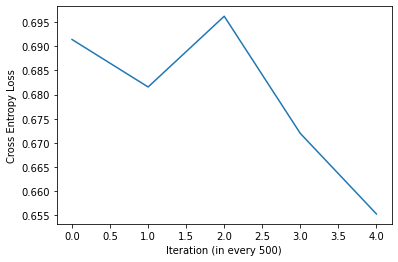

In [ ]:
#HYPERPARAMETERS
batch_size = 150
num_iters = 3000
learning_rate = 0.001

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## SETTING 9: Iteration Number=2500

Total training data= 27747
Total testing data= 3083
Current Time = 06:32:14
Batch size: 150 ; Number of iterations: 2500 ; Learning rate: 0.001 ; Total training data size: 27747 ; Epoch size: 13
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6938565373420715. Accuracy: 54.200454103146285
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6939563751220703. Accuracy: 56.60071359065845
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6760027408599854. Accuracy: 57.80084333441453
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6766151189804077. Accuracy: 58.48199805384366
Epoch: 12
Epoch: 13
-----------------------Simulation ends----------------------
Current Time = 06:32:19
[0.6938565373420715, 0.6939563751220703, 0.6760027408599854, 0.6766151189804077]


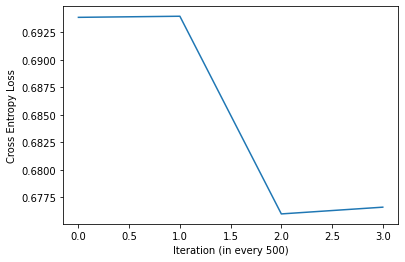

In [ ]:
#HYPERPARAMETERS
batch_size = 150
num_iters = 2500
learning_rate = 0.001

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## **OBSERVATIONS AFTER EXPERIMENTING WITH ITERATIONS:-**


---
Now we can compare the data for the 5 settings, where the learning rate, batch-size and optimizer were static and only the iterations was varied, in order to determine which iterations we will use moving forward. A table is shown as follows:

|     Criteria     | Iterations = 5000 | Iterations = 20000 | Iterations = 10000 | Iterations = 3000 | Iterations = 2500 |
| :--------------- | :--------------: | :-------------: | :--------------: | :--------------: | :--------------: |
| Initial Accuracy |      55.62%      |     53.90%      |      54.91%      |     56.08%      |      54.20%      |
| Highest Accuracy |      59.55%      |     **59.90%**      |      59.77%      |     58.90%      |      58.48%      |
| Final Accuracy   |      59.16%      |     59.68%      |      **59.74%**      |     58.90%      |      58.48%      || 

Here, we can see that the highest accuracy (59.90%) was achieved for **Iterations=20000** while the highest final accuracy (59.74%) was achieved with **Iterations = 10000**. While it is possible that 20000 iterations might give better results in certain settings, the possibility of overfitting also becomes high in this case. So we will settle for the **highest final accuracy(59.74%)** which was achieved for **Iterations = 10000** and moving forward, we will use this value for the subsequent experiments.

# EXPERIMENTING WITH LEARNING RATE
Now we will attempt to tune the hyper-parameter **learning-rate**. So we will perform 4 experiments. As we have already seen the performance of **learning-rate = 0.001**, now we will try the same experiment with 4 other values, which are:
* Learning-rate: 0.01
* Learning-rate: 0.005
* Learning-rate: 0.0002
* Learning-rate: 0.0001

Here, 2 values are higher than the baseline value that was used (multiplying baseline LR by 5 and 10), and 2 are lower (dividing baseline LR by 5 and 10). By this gradual increasing and decreasing process, we can determine which value will be optimal for the hyper-parameter in the subsequent experiments for tuning the other hyperparameters. The values of the other hyper-parameters will remain constant for these 4 experiments:
* Batch-size: 150
* Iterations: 10000
* Optimizer: SGD


## SETTING 10: LR=0.01

Total training data= 27747
Total testing data= 3083
Current Time = 06:41:32
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.01 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6636926531791687. Accuracy: 58.709049626986705
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6800781488418579. Accuracy: 59.4550762244567
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6651373505592346. Accuracy: 59.3577684073954
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.7040868401527405. Accuracy: 60.00648718780409
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6553136110305786. Accuracy: 58.77392150502757
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6378768682479858. Accuracy: 59.422640285436266
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6792047023773193. Accuracy: 59.55238404151

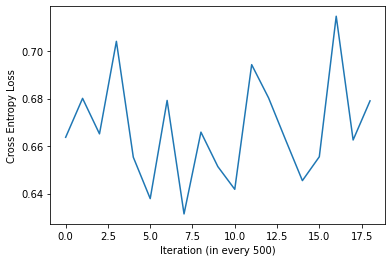

In [ ]:
#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.01

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## SETTING 11: LR=0.005

Total training data= 27747
Total testing data= 3083
Current Time = 06:42:22
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.005 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6849959492683411. Accuracy: 58.25494648070062
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6832090616226196. Accuracy: 60.00648718780409
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6802404522895813. Accuracy: 59.68212779759974
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6457663178443909. Accuracy: 59.844307492701915
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6805881261825562. Accuracy: 59.77943561466105
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6995463371276855. Accuracy: 59.97405124878365
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6859155297279358. Accuracy: 59.779435614

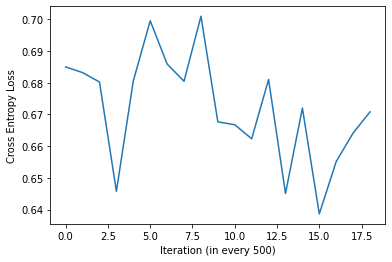

In [ ]:
#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.005

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## SETTING 12: LR=0.0002

Total training data= 27747
Total testing data= 3083
Current Time = 06:42:47
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.0002 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6899726390838623. Accuracy: 50.60006487187804
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.7156214714050293. Accuracy: 51.73532273759325
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.7140589952468872. Accuracy: 53.45442750567629
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6900672316551208. Accuracy: 54.200454103146285
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6943855881690979. Accuracy: 54.33019785922802
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6733835935592651. Accuracy: 55.043788517677584
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6870679259300232. Accuracy: 55.3681479

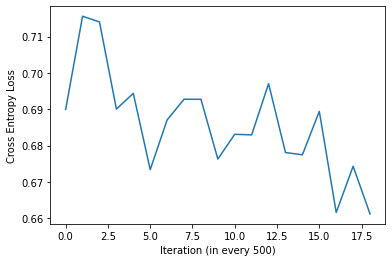

In [ ]:
#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.0002

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## SETTING 13: LR=0.0001

Total training data= 27747
Total testing data= 3083
Current Time = 06:41:57
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.0001 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6964185833930969. Accuracy: 50.85955238404152
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.7071293592453003. Accuracy: 51.183911774245864
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.7143867015838623. Accuracy: 51.119039896204995
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6956008672714233. Accuracy: 51.63801492053195
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.7134397625923157. Accuracy: 52.44891339604281
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6954474449157715. Accuracy: 52.44891339604281
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6880731582641602. Accuracy: 52.7084009

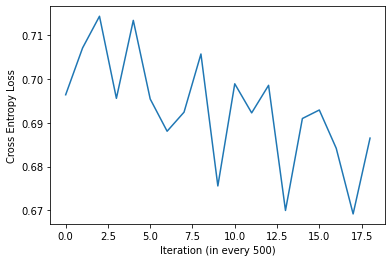

In [ ]:
#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.0001

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)


## **OBSERVATIONS AFTER EXPERIMENTING WITH LEARNING RATE:-**


---
Now we can compare the data for the 5 settings, where the iterations, batch-size and optimizer were static and only the learning rate was varied, in order to determine which learning rate we will use moving forward. A table is shown as follows:

|     Criteria     | LR = 0.001 | LR = 0.01 | LR = 0.005 | LR = 0.0002 | LR = 0.0001 |
| :--------------- | :--------------: | :-------------: | :--------------: | :--------------: | :--------------: |
| Initial Accuracy |      54.91%      |     58.07%      |      **58.25%**      |     50.60%      |      50.85%      |
| Highest Accuracy |      59.77%      |     60.00%      |      **60.03%**      |     58.22%      |      55.49%      |
| Final Accuracy   |      **59.74%**      |     59.58%      |      59.45%      |     58.22%      |      55.49%      || 

Here, we can see that the highest accuracy (60.03%) was achieved for **LR = 0.005** while the highest final accuracy (59.74%) was achieved with **LR = 0.001**. As **LR = 0.005** tended to give better results from the very beginning of the experiment, moving forward we will use this value for the subsequent experiments.


# EXPERIMENTING WITH OPTIMIZERS
Now we will attempt to select an optimizer that performs the best with the 3 chosen hyper-parameters. So we will perform 7 experiments. As we have already seen the performance of **SGD**, now we will try the same experiment with 7 other optimizers, which are:
* Adagrad
* ASGD
* RMSprop
* Rprop
* Adam
* Adamax
* AdamW

The values of the other hyper-parameters will remain constant for these 7 experiments:
* Batch-size: 150
* Iterations: 10000
* Learning Rate: 0.005


## SETTING 14: Optimizer Adagrad

Total training data= 27747
Total testing data= 3083
Optimizer being used: Adagrad
Current Time = 06:52:29
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.0005 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6920772194862366. Accuracy: 58.35225429776192
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6950879096984863. Accuracy: 58.709049626986705
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6552503705024719. Accuracy: 59.19558871229322
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6670326590538025. Accuracy: 59.3577684073954
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6750068068504333. Accuracy: 59.71456373662018
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6925894618034363. Accuracy: 59.68212779759974
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6512876152

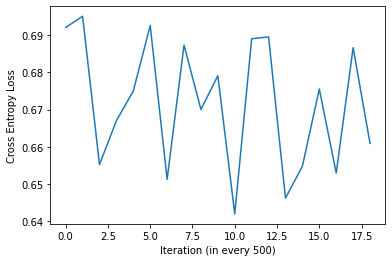

In [ ]:
def model_and_optimizer(l_rate):
  '''
  INSTANTIATE MODEL CLASS
  '''
  learning_rate=l_rate
  model = LogisticRegressionModel(input_size=input_dim,
                                  num_classes=output_dim)
  # To enable GPU
  model.to(device)

  # INSTANTIATE OPTIMIZER CLASS
  optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
  return optimizer,model

#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.0005

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
print("Optimizer being used: Adagrad")
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)

## SETTING 15: Optimizer ASGD

Total training data= 27747
Total testing data= 3083
Optimizer being used: ASGD
Current Time = 06:55:01
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.0005 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6746816039085388. Accuracy: 50.98929614012326
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.7016182541847229. Accuracy: 53.6490431397989
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6845647692680359. Accuracy: 54.71942912747324
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6919088959693909. Accuracy: 55.78981511514758
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.683534562587738. Accuracy: 56.2763542004541
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6805996894836426. Accuracy: 56.860201102821925
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.692753732204437

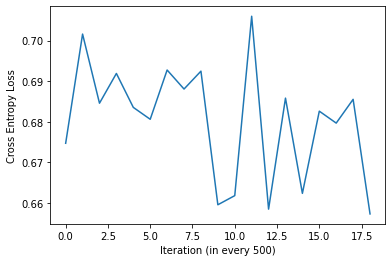

In [ ]:
def model_and_optimizer(l_rate):
  '''
  INSTANTIATE MODEL CLASS
  '''
  learning_rate=l_rate
  model = LogisticRegressionModel(input_size=input_dim,
                                  num_classes=output_dim)
  # To enable GPU
  model.to(device)

  # INSTANTIATE OPTIMIZER CLASS
  optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
  return optimizer,model

#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.0005

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
print("Optimizer being used: ASGD")
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)

## SETTING 16: Optimizer RMSprop

Total training data= 27747
Total testing data= 3083
Optimizer being used: RMSprop
Current Time = 06:55:26
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.0005 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.7010642886161804. Accuracy: 58.87122932208887
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.642734706401825. Accuracy: 59.26046059033409
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6578694581985474. Accuracy: 59.422640285436266
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6581366658210754. Accuracy: 59.19558871229322
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6791887283325195. Accuracy: 58.87122932208887
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6680316925048828. Accuracy: 58.28738241972105
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6591780185

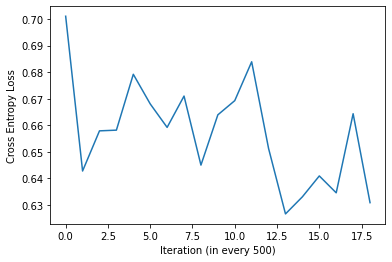

In [ ]:
def model_and_optimizer(l_rate):
  '''
  INSTANTIATE MODEL CLASS
  '''
  learning_rate=l_rate
  model = LogisticRegressionModel(input_size=input_dim,
                                  num_classes=output_dim)
  # To enable GPU
  model.to(device)

  # INSTANTIATE OPTIMIZER CLASS
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
  return optimizer,model

#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.0005

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
print("Optimizer being used: RMSprop")
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)

## SETTING 17: Optimizer Rprop

Total training data= 27747
Total testing data= 3083
Optimizer being used: Rprop
Current Time = 06:55:52
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.0005 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6725062131881714. Accuracy: 55.95199481024976
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6600448489189148. Accuracy: 55.98443074927019
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6659494042396545. Accuracy: 56.21148232241323
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6861338019371033. Accuracy: 56.470969834576714
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6864727735519409. Accuracy: 56.503405773597144
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6586239337921143. Accuracy: 57.08725267596497
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6685937047

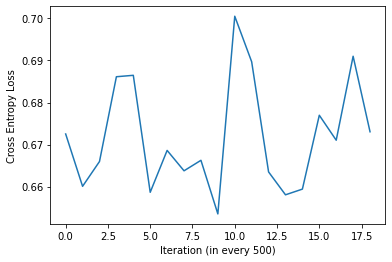

In [ ]:
def model_and_optimizer(l_rate):
  '''
  INSTANTIATE MODEL CLASS
  '''
  learning_rate=l_rate
  model = LogisticRegressionModel(input_size=input_dim,
                                  num_classes=output_dim)
  # To enable GPU
  model.to(device)

  # INSTANTIATE OPTIMIZER CLASS
  optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
  return optimizer,model

#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.0005

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
print("Optimizer being used: Rprop")
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)

## SETTING 18: Optimizer Adam

Total training data= 27747
Total testing data= 3083
Optimizer being used: Adam
Current Time = 06:59:00
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.0005 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6602463722229004. Accuracy: 58.96853713915018
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6667368412017822. Accuracy: 59.941615309763215
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6656136512756348. Accuracy: 59.909179370742784
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6576622724533081. Accuracy: 59.6496918585793
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6508894562721252. Accuracy: 59.941615309763215
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6571237444877625. Accuracy: 59.97405124878365
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.63135439157

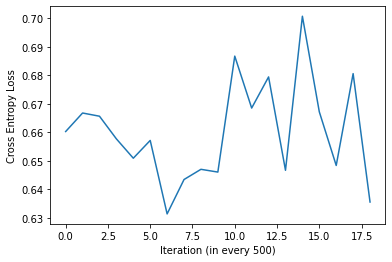

In [ ]:
def model_and_optimizer(l_rate):
  '''
  INSTANTIATE MODEL CLASS
  '''
  learning_rate=l_rate
  model = LogisticRegressionModel(input_size=input_dim,
                                  num_classes=output_dim)
  # To enable GPU
  model.to(device)

  # INSTANTIATE OPTIMIZER CLASS
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return optimizer,model

#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.0005

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
print("Optimizer being used: Adam")
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)

## SETTING 19: Optimizer Adamax

Total training data= 27747
Total testing data= 3083
Optimizer being used: Adamax
Current Time = 06:59:26
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.0005 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6841640472412109. Accuracy: 60.72007784625365
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6829507946968079. Accuracy: 60.265974699967565
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6510809659957886. Accuracy: 60.36328251702887
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.7044245600700378. Accuracy: 60.3957184560493
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.6760891079902649. Accuracy: 59.941615309763215
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6453441977500916. Accuracy: 60.42815439506974
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6759979128

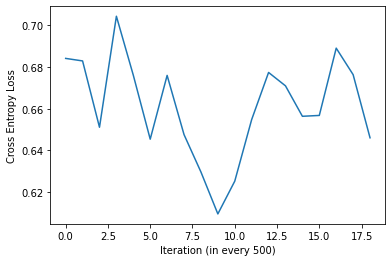

In [ ]:
def model_and_optimizer(l_rate):
  '''
  INSTANTIATE MODEL CLASS
  '''
  learning_rate=l_rate
  model = LogisticRegressionModel(input_size=input_dim,
                                  num_classes=output_dim)
  # To enable GPU
  model.to(device)

  # INSTANTIATE OPTIMIZER CLASS
  optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
  return optimizer,model

#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.0005

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
print("Optimizer being used: Adamax")
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)

## SETTING 20: Optimizer AdamW

Total training data= 27747
Total testing data= 3083
Optimizer being used: AdamW
Current Time = 07:04:12
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.0005 ; Total training data size: 27747 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.6560892462730408. Accuracy: 59.03340901719105
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.6497491598129272. Accuracy: 60.03892312682452
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.6573033928871155. Accuracy: 59.6496918585793
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6431840658187866. Accuracy: 59.29289652935452
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.689477264881134. Accuracy: 59.22802465131365
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6695065498352051. Accuracy: 58.83879338306844
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.67162221670150

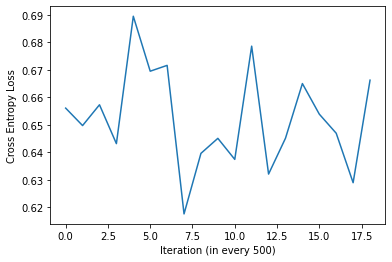

In [ ]:
def model_and_optimizer(l_rate):
  '''
  INSTANTIATE MODEL CLASS
  '''
  learning_rate=l_rate
  model = LogisticRegressionModel(input_size=input_dim,
                                  num_classes=output_dim)
  # To enable GPU
  model.to(device)

  # INSTANTIATE OPTIMIZER CLASS
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  return optimizer,model

#HYPERPARAMETERS
batch_size = 150
num_iters = 10000
learning_rate = 0.0005

optimizer,model=model_and_optimizer(learning_rate)
num_train,train_load,test_load=data_splitting_and_loading(num_iters,batch_size)
print("Optimizer being used: AdamW")
model_training(batch_size,num_iters,learning_rate,num_train,train_load,test_load,optimizer,model)

## **OBSERVATIONS AFTER EXPERIMENTING WITH OPTIMIZERS:-**


---
Now we can compare the data for the 8 settings, where the iterations, batch-size and learning-rate were static and only the Optimizer was varied, in order to determine which optimizer performs the best with the selected hyper-parameters. A table is shown as follows:

|     Criteria     | SGD | Adagrad | ASGD | RMSprop | Rprop | Adam | Adamax | AdamW |
| :--------------- | :--------------: | :-------------: | :--------------: | :--------------: | :--------------: | :--------------: | :--------------: | :--------------: |
| Initial Accuracy |      58.25%      |     58.35%      |      50.98%      |     58.87%      |      55.95%      |      58.96%      |     **60.72%**      |      59.03%      |
| Highest Accuracy |      60.03%      |     60.20%      |      58.54%      |     59.68%      |      58.38%      |      59.97%      |     **60.72%**      |      60.03%      |
| Final Accuracy   |      59.45%      |     **60.16%**      |      58.54%      |     58.90%      |      58.38%      |      58.77%      |     59.38%      |      58.15%      || 

Here, we can see that the highest overall accuracy (60.72%) was achieved for **Adamax**, but the accuracy gradually decreased. While the highest final accuracy (60.16%) was achieved with **Adagrad**. As **Adagrad** tended to give better results from the very beginning of the experiment and consistently till the end, we can consider this the best optimizer for the selected hyper-parameters in this experiment, among the ones brought into consideration.


# Comparison of results:

---

Here we can see a comparison of all the settings we have implemented in this experiment.

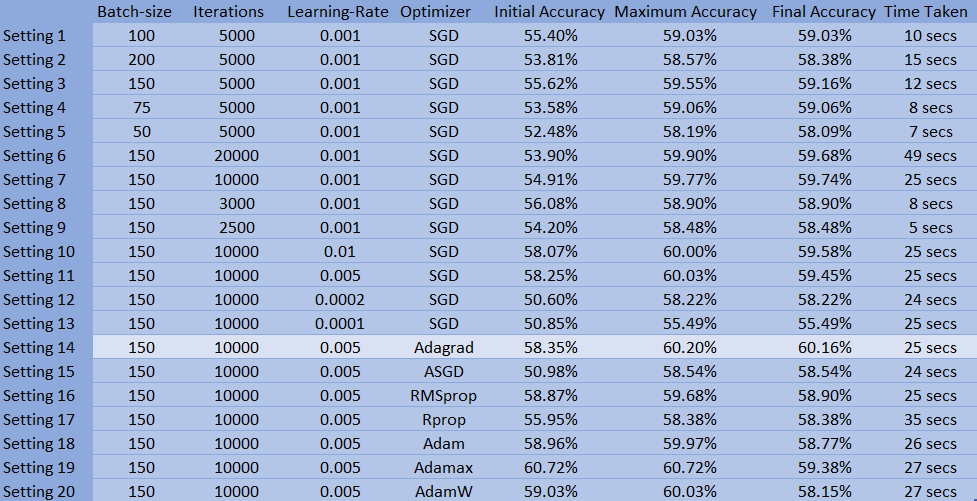

**In conclusion: Adagrad optimizer used alongside hyper-parameters:- Batch-size=150, iteration=10000, learning rate=0.005 gave the best accuracy among the 20 experiments conducted.**